In [1]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
#from agent import neural_network
import seaborn as sns
from agent import DQN
import pandas as pd

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir_lr = save_path / "7-8-LR"
data_dir_ew = save_path / "7-8-EW"
print(data_dir_lr.exists())
print(data_dir_ew.exists())

True
True


In [5]:
data_path_lr = data_dir_lr / "data.tar" 
print(data_path_lr.exists())
data_path_ew = data_dir_ew / "data.tar"
print(data_path_ew.exists())

True
True


In [6]:
data_dict_lr = torch.load(data_path_lr, weights_only=False, map_location=DEVICE)
#data_dict_lr.keys()
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
#data_dict_ew.keys()

In [9]:
# ASSUMING EQUAL ARCHITECTURES
parameters = data_dict_lr['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [10]:
model = DQN(n_observations, n_actions, n_units)

In [11]:
model_path = data_dir_ew / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

# Extracting Model Weights
state_dict = model.state_dict()
layer0_weights = state_dict['mlp.0.weight']
layer1_weights = state_dict['mlp.1.weight']
layer2_weights = state_dict['mlp.3.weight']
layer3_weights = state_dict['mlp.5.weight']
layer4_weights = state_dict['mlp.7.weight']
weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]

In [12]:
first_layer_weights = weights[0]

In [13]:
dominant_inputs = np.argmax(np.abs(first_layer_weights), axis=1)  # shape: (512,)
print(dominant_inputs)

tensor([ 1,  0,  3,  1,  1, 18, 14, 17,  0,  2, 12,  2,  1,  1,  2,  1, 16, 11,
         1,  1,  0, 20,  2, 12,  0,  5, 10, 13, 20,  2,  2,  0,  0,  1,  1,  3,
         0, 15,  0, 17,  6, 10,  2,  1, 15, 11, 11,  5, 19,  9, 10, 17, 20,  0,
        19, 14,  8,  0,  4,  7,  8, 12,  0,  9, 19,  0,  9, 13, 18, 18, 14,  1,
         2,  1,  6,  9, 10, 12, 15,  2,  0,  0, 14,  4,  2,  0, 14, 12, 15, 18,
         2,  7,  3,  7,  1,  2,  0,  7, 19,  0,  2,  2, 19, 19,  0,  6,  1,  6,
         0, 14, 13, 15,  1,  5,  7, 14,  0,  8,  2,  0,  1,  9,  0,  2,  7,  0,
        10, 19, 17, 18,  5,  1,  0,  6, 16,  0, 13,  1, 18, 19,  9,  0, 11,  0,
        12,  1,  5,  4,  0, 18,  0,  9,  2,  6,  2, 10, 15,  9,  1,  0, 14, 14,
        15,  0, 15,  0,  6,  0,  5, 17,  4,  1,  0, 13,  2,  2, 19,  2,  7,  6,
        17,  0,  0,  5, 12, 18,  9,  2,  2,  6, 14, 10, 16,  0, 13, 19,  3,  0,
         0,  3,  3, 11,  0,  1, 19,  7,  0,  2, 13,  3, 20,  2,  8, 10, 15, 14,
         1, 16, 14, 16, 20, 20,  9, 15, 

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_32015/2023146609.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dominant_inputs = np.argmax(np.abs(first_layer_weights), axis=1)  # shape: (512,)


In [49]:
from sklearn.preprocessing import StandardScaler

weights_std = StandardScaler().fit_transform(first_layer_weights)

In [51]:
from sklearn.preprocessing import normalize

weights_norm = normalize(first_layer_weights, norm='l2')

In [40]:
from sklearn.metrics.pairwise import cosine_distances

cosine_dist = cosine_distances(first_layer_weights)  # or weights_std

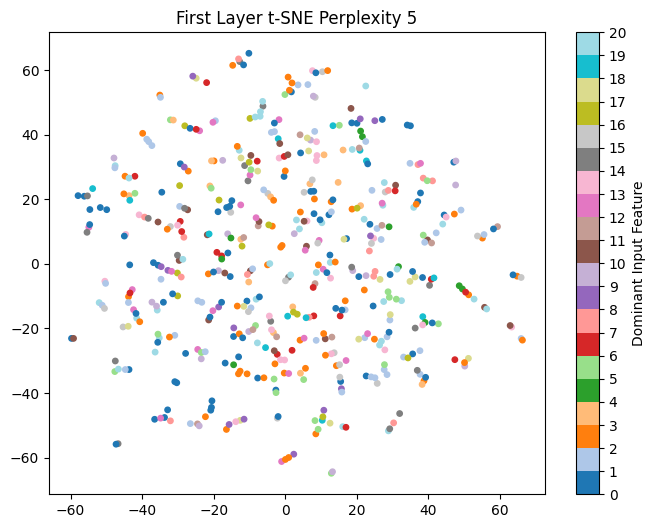

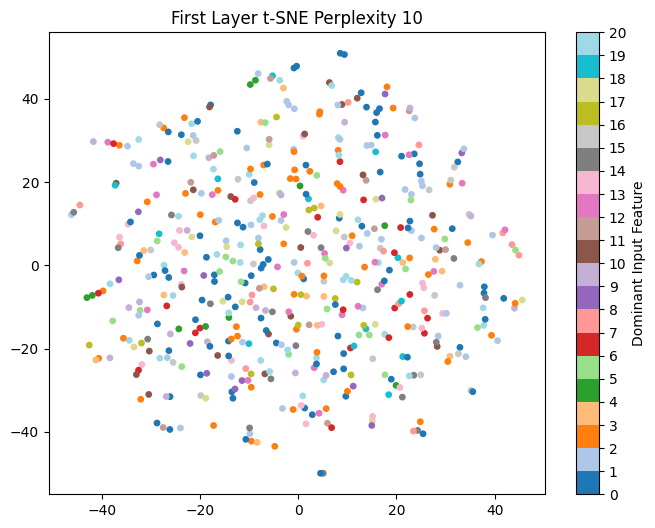

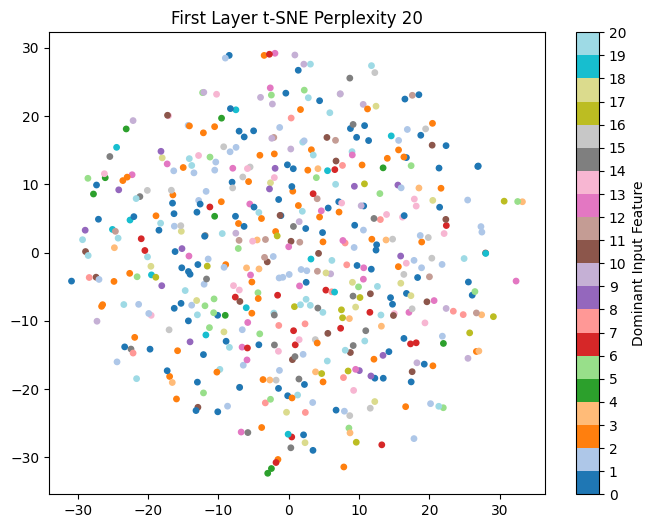

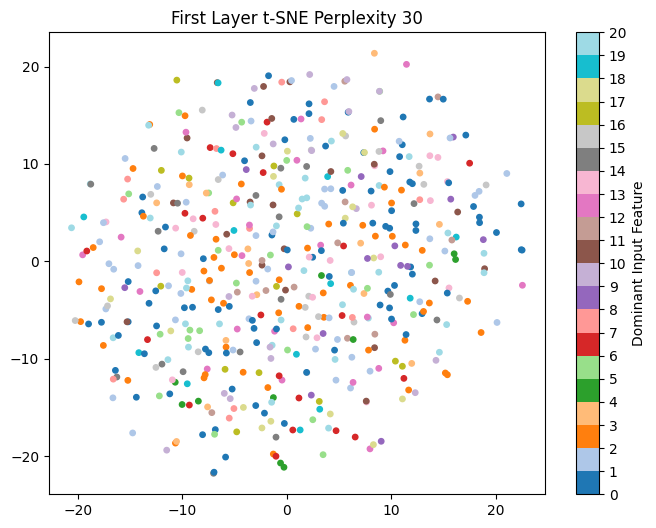

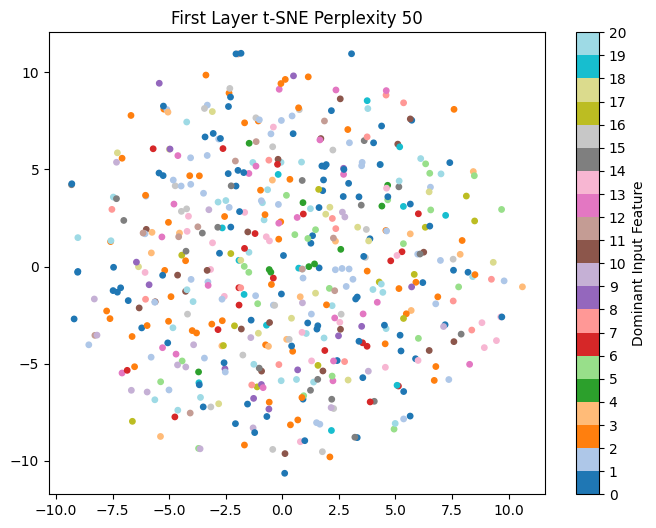

In [16]:
from sklearn.manifold import TSNE

for p in [5, 10, 20, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=p, learning_rate=200, init='pca')
    embedding = tsne.fit_transform(first_layer_weights)  # shape: (512, 2)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=dominant_inputs, cmap='tab20', s=15)
    plt.colorbar(scatter, ticks=range(21), label='Dominant Input Feature')
    plt.title(f"First Layer t-SNE Perplexity {p}")
    plt.savefig(f'figures/ewfirstlayertSNEp{p}.png', dpi=300, bbox_inches = 'tight')
    plt.show()